In [1]:
import os
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import time

from _3dpu_mehdi  import *

In [2]:
!pip3 install ipympl
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
chemin = r"C:\Users\0\OneDrive\Documents\Montréal 4A\Les études\Chair AI-SCALE\ph.nii"
phase_image = nb.load( chemin)
x_min,x_max = 60,140
y_min,y_max = 60,140
z_min,z_max = 10,60
t = 1
data = phase_image.get_data()[x_min:x_max,y_min:y_max,z_min:z_max,1]
#data = phase_image.get_data()[:,:,:,1]

C:\Users\0\AppData\Local\Temp\ipykernel_39868\2249129986.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = phase_image.get_data()[x_min:x_max,y_min:y_max,z_min:z_max,1]


In [5]:
chemins, P,cheminement = [],[0],[]

In [6]:
Sat = all_residuals(data)
with open('readme.txt', 'w') as f:
    Sat = residual_loops(chemins,f,Sat)
    

new il reste240
new il reste237
new il reste234
new il reste232
new il reste228
new il reste226
new il reste226
new il reste223
new il reste223
new il reste217
new il reste217
new il reste217
new il reste213
new il reste209
new il reste209
new il reste199
new il reste195
new il reste179
new il reste173
new il reste173
new il reste169
new il reste169
new il reste169
new il reste169
new il reste162
new il reste159
new il reste155
new il reste137
new il reste137
new il reste137
new il reste131
new il reste131
new il reste131
new il reste131
new il reste128
new il reste128
new il reste125
new il reste122
new il reste122
new il reste122
new il reste122
new il reste112
new il reste112
new il reste112
new il reste82
new il reste78
new il reste78
new il reste78
new il reste70
new il reste70
new il reste70
new il reste70
new il reste64
new il reste60
new il reste57
new il reste57
new il reste57
new il reste57
new il reste57
new il reste49
new il reste49
new il reste49
new il reste44
new il rest

(-31.5, 38.0)

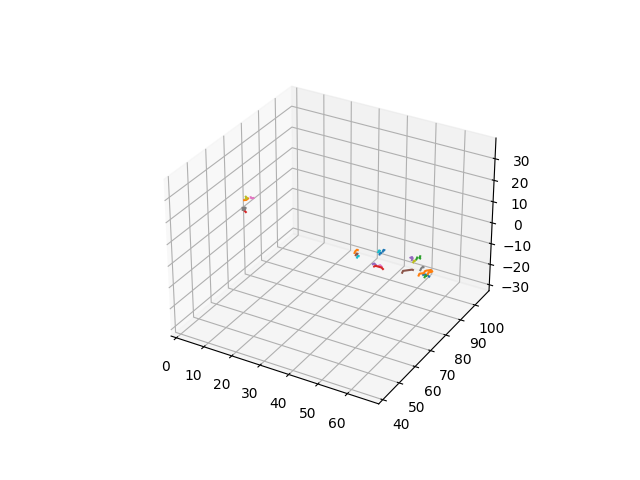

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
X = []
Y = []
Z = []
for idx,ch in chemins[0:]:
    if idx == 0:
        lasso_positions = []
        for pos in ch:
            if pos[0] == 2:
                new_pos = [pos[1]+0.5,pos[2] + 0.5,pos[3]]
            elif pos[0] == 1:
                new_pos = [pos[1]+0.5,pos[2],pos[3]+0.5]
            elif pos[0] == 0:
                new_pos = [pos[1],pos[2] + 0.5,pos[3]+0.5]
                
            lasso_positions.append(new_pos)
        xs = [pos[0] for pos in lasso_positions]
        ys = [pos[1] for pos in lasso_positions]
        zs = [pos[2] for pos in lasso_positions]
        ax.plot(xs,ys,zs)
        Z = Z + zs
        X = X + xs
        Y = Y + ys

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 + 0.5

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

